# NumMod 2023: Seminar 3 (Finite Element Method)

* We use basis functions that are piecewise linear (more precisely, piecewise affine) with respect to mesh:
$$
    u_h(x) = \sum_{i=1}^N c_i v_i(x)
$$

* In 2D it looks like this:
<img width="50%" src="fig/FEM_basis_2D.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 5
test_x, test_y = np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n))
test_x_f = test_x.flatten()
test_y_f = test_y.flatten()
points = np.column_stack((test_x_f, test_y_f))

In [3]:
triangles_u = []
triangles_l = []
for i in range (0,n**2):
    # condition for upper triangles
    if (i+1)%n != 0 and (i+n) < n**2:
        triangles_u.append([i,i+1,i+n])
    
    # condition for lower triangles
    if (i+1)%n != 0 and (i+n+1) < n**2:
        triangles_l.append([i+1,i+n,i+n+1])

triangles = np.array((triangles_u + triangles_l))

# sort triangles lexicographically
# triangles = triangles[np.lexsort(np.rot90(triangles))]

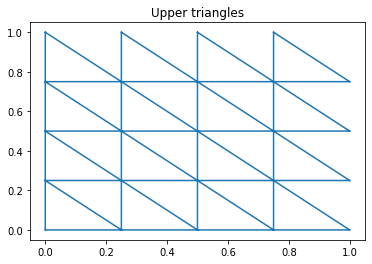

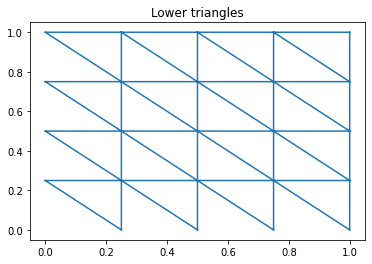

In [4]:
plt.triplot(test_x_f, test_y_f, triangles_u)
plt.title("Upper triangles")
plt.show()

plt.triplot(test_x_f, test_y_f, triangles_l)
plt.title("Lower triangles")
plt.show()

### Return back and create denser grid

In [5]:
# Get the number of nodes and triangles
N = points.shape[0]
T = triangles.shape[0]

print(np.shape(points))
print(np.shape(triangles))

(25, 2)
(32, 3)


### Assembling the matrix

Classical way:

* Notice that $\nabla v_k$ are piecewise constant:
$$
A_{k,\ell}
= \int_{\Omega} \nabla v_k \cdot \nabla v_\ell
= \sum_{T\in\mathcal T} |T| (\nabla v_k|_T) \cdot (\nabla v_\ell|_T),
$$
where $|T|$ is the volume or area of $T$

* Pseudocode:
```
for k = 1 to n
  for l = 1 to n
    for all T
      if(k and l are nodes of T)
      // otherwise the integral is zero
        A(k,l) += |T|
           *(\nabla v_k|_T)
           *(\nabla v_l|_T)
```

* The loops in the algorithm are often reversed:
```
for all T
    for k, vertices of T
        for l, vertices of T
            A(k,l) += M_T(k,l)
```
where $M^T_{kl}=|T| (\nabla v_k|_T) \cdot (\nabla v_\ell|_T)$

* $|T|$ can be calculated as half square of correspondind parallelogramm
$$
2 |T| = \det \left(
\begin{array}{cc}
x _2 - x _1 & y _2 - y _1 \\
x _3 - x _1 & y _3 - y _1 \\
\end{array}
\right)
$$

<img width="50%" src="fig/det_square.png">



* Let $T$'s nodes being $p_1\{x_1,y_1\}$, $p_2\{x_2,y_2\}$, $p_3\{x_3,y_3\}$. 
Denote $v^T_i = v_{p_i}$ defined inside $T$.
Then $v^T_i$ is an equation of plane passing through the points
$$
\begin{equation}
\{x_{(i+1)\%3}, y_{(i+1)\%2}, 0\} \\
\{x_{(i+2)\%3}, y_{(i+2)\%3}, 0\} \\
\{x_{i}, y_{i}, 1\}.
\end{equation}
$$

* Then it can be shown
$$
\nabla v^T_{i} = \frac{1}{2|T|}
\left(
\begin{array}{cc}
y_1 - y_2 \\
x_2 - x_1 \\
\end{array}
\right)
$$
Hint: $\vec{n} = \{A, B, C\} = \overrightarrow{p_2-p_1} \times \overrightarrow{p_3-p_1}$.


* Pseudocode:
```
for all T
    calculate M_T
    for k=1..3
        for l=1..3
            A(nodes(k),nodes(l)) += M_T(k,l)
```
where matrix $M^T_{kl} = \frac{1}{4|T|} |\nabla v^T_k| |\nabla v^T_l| $

### Assembling the right-hand side (forces)

$$
\int_T f v^T_i \approx f(x_S, y_S) \int_T v^T_i = \frac{f(x_S, y_S)}{3|T|}
$$
where $(x_S,y_S)$ is the center of mass of the triangle. 

Hint: the parallelepiped spanned by $\{\vec{a}, \vec{b}, \vec{c}\}$ has (oriented) volume $\det(\vec{a}, \vec{b}, \vec{c})$.
The pyramid has $\frac{1}{6}$ of this volume.


* Pseudocode:
```
for all T
    calculate f(xS, yS)
    for k=1..3
        f(nodes(k)) += 1/3 * area(T) * f(xS, yS)
```

### How about boundary conditions?

* pseudocode:
```
A = zero matrix for free nodes
for k = free nodes
    for l = free nodes
        for all T
            A(k,l) = 1 if k==l else 0
```
This fills only the needed rows & columns of the matrix, but for convenience the loops in the algorithm are often reversed:

* pseudocode
```
A = zero matrix for all nodes
for all T
    <<SAME AS FOR ORDINARY NODES>>
remove rows and columns from A corr. to non-free nodes
```

* The **free nodes** are those that are on $\Gamma_2$ in
$$
\begin{align*}
-\Delta u &= 0\qquad\text{on $\Omega$}
\\
u &= 0\qquad\text{on $\Gamma_1$}
\\
u_n &= 0\qquad\text{on $\Gamma_2$}
\end{align*}
$$

* Alternatively, one can **replace** the corresponding row and column by
$$
\begin{pmatrix}
\cdot & 0 & \cdot & \cdot \\
0 & 1 & 0 & 0\\
\cdot & 0 & \cdot & \cdot \\
\cdot & 0 & \cdot & \cdot \\
\end{pmatrix}
$$

### Solve the simple problem $-\Delta u = 1$, Dirichlet boundary conditions

In [6]:
# Solve the simplest problem -Du = 1, Dirichlet boundary conditions

def Solver(p,t,N,T):
    A = np.zeros((N,N))
    b = np.zeros(N)

    # One big loop for all triangles
    for i in range(0,T):

        # Extract the vertices of the triangles
        p1 = p[int(t[i,0]),:2] #x1,y1
        p2 = p[int(t[i,1]),:2] #x2,y2
        p3 = p[int(t[i,2]),:2] #x3,y3

        verts = np.stack((p1, p2, p3)) # Put vertices into one array

        # Find the area of the triangle
        T_area = np.abs(np.linalg.det([[p2[0]-p1[0],p2[1]-p1[1]],[p3[0]-p1[0],p3[1]-p1[1]]])/2)

        # Loop for the nodes
        for k in range(0,3):
            for j in range(0,3):

                # Index
                k1 = (k+1)%3
                k2 = (k+2)%3
                j1 = (j+1)%3
                j2 = (j+2)%3

                # Gradients
                grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
                grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])

                # Fill the matrix
                A[int(t[i,j]),int(t[i,k])] += 1./(4*T_area)*np.dot(grad1,grad2) 
              
            
          
            # Right hand side
            b[int(t[i,k])] += 1/3*T_area;

    # Boundary Conditions
    for n in range(0,N):
        if p[n,0] == 0.0 or p[n,1] == 0.0 or p[n,0] == 1.0 or p[n,1] == 1.0:
            A[n,:] = 0
            A[:,n] = 0
            A[n,n] = 1
            b[n] = 0
    
    # Check condition number
    print(f"Condition number of A={np.linalg.cond(A):.5f}")

    sol = np.linalg.solve(A, b)
    return sol, A, b

In [7]:
sol, A, b  = Solver(points, triangles, N, T)

Condition number of A=6.82843


In [8]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm

In [9]:
def plot_img(p, sol):
    p1_new, p2_new, sol_new = zip(*sorted(zip(p[:,0], p[:,1], sol)))
    grid_x, grid_y = np.meshgrid(np.linspace(0,1,1000), np.linspace(0,1,1000))

    Interp_sol = griddata((p[:,0], p[:,1]), sol, (grid_x, grid_y), method='cubic')

    fig, ax = plt.subplots(1,2, figsize=(10,10))

    im1 = ax[0].imshow(Interp_sol, cmap=cm.coolwarm, vmin=abs(sol).min(), vmax=abs(sol).max())
    im2 = ax[1].imshow(Interp_sol, cmap=cm.Accent, vmin=abs(sol).min(), vmax=abs(sol).max())

    cb = fig.colorbar(im2, ax=ax)
    cb = fig.colorbar(im1, ax=ax)

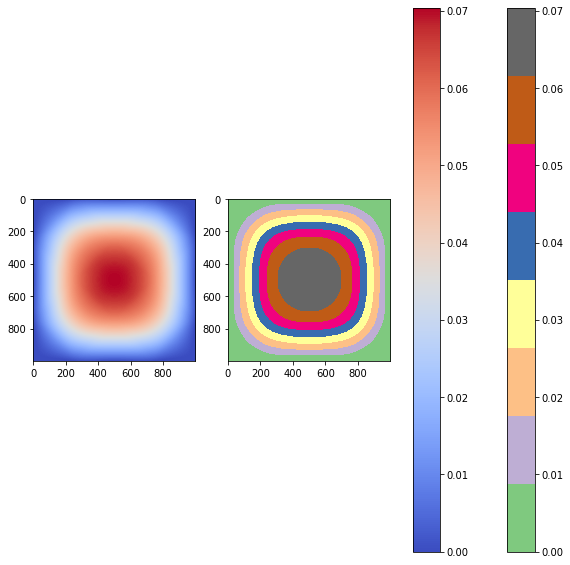

In [10]:
plot_img(points,sol)

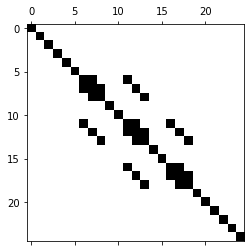

In [11]:
plt.spy(A)
plt.show()